# SIMULACIÓN ESTOCÁSTICA DE EDEs CON CRECIMIENTO SUBLINEAL
Este notebook implementa el esquema TPPE (Truncated Positivity-Preserving Euler)
para simular ecuaciones diferenciales estocásticas con deriva sublineal.

Objetivo: Verificar la hipótesis de extinción casi segura para diferentes valores
del parámetro θ que controla el tipo de crecimiento poblacional.

In [ ]:
!pip install --upgrade "jax[cuda12]"

In [ ]:
import jax
import jax.numpy as jnp
from jax import random, jit, vmap, lax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial
from scipy import stats

# Configurar JAX para usar precisión de 64 bits (crítico para estabilidad numérica)
jax.config.update("jax_enable_x64", True)

print(f"JAX version: {jax.__version__}")
print(f"Dispositivos disponibles: {jax.devices()}")

JAX version: 0.8.1
Dispositivos disponibles: [CudaDevice(id=0)]


# DEFINICIÓN DEL MODELO (JIT COMPILED)

## Cuerpo Modelo

In [ ]:
@jit
def drift(z, theta, K=10.0):
    """
    Calcula la función de deriva b(z) que depende de θ.

    Para θ ≠ 0: b(z) = z * (1 - z^θ) / θ
    Para θ = 0: b(z) = z * log(1/z) (límite de Gompertz)

    Args:
        z: Valor actual de la población
        theta: Parámetro de forma del crecimiento
        K: Capacidad de carga (no afecta la deriva pero se mantiene por consistencia)

    Returns:
        Valor de la deriva en z
    """
    # Usamos jnp.where para manejar el caso θ=0 sin bifurcaciones
    # Esto es más eficiente en JAX que usar condicionales explícitos

    # Caso θ ≠ 0
    drift_nonzero = z * (1.0 - jnp.power(z, theta)) / theta

    # Caso θ = 0 (Gompertz): usar log(1/z) = -log(z)
    # Agregamos un pequeño epsilon para evitar log(0)
    drift_zero = z * jnp.log(jnp.maximum(1.0 / z, 1e-10))

    # Seleccionar según el valor de theta
    return jnp.where(jnp.abs(theta) < 1e-10, drift_zero, drift_nonzero)

In [ ]:
@jit
def diffusion(z, theta, K=10.0, alpha=0.1):
    """
    Calcula la función de difusión σ(z) que controla la intensidad del ruido.

    Para θ ≠ 0: σ(z) = sqrt(z/(K|θ|) * (1 + 2α|θ| + z^θ))
    Para θ = 0: σ(z) = sqrt(z/K * (|log(z)| + 2α))

    Args:
        z: Valor actual de la población
        theta: Parámetro de forma del crecimiento
        K: Capacidad de carga
        alpha: Parámetro de intensidad del ruido

    Returns:
        Valor de la difusión en z
    """
    # Caso θ ≠ 0
    abs_theta = jnp.abs(theta)
    term = 1.0 + 2.0 * alpha * abs_theta + jnp.power(z, theta)
    diffusion_nonzero = jnp.sqrt(z / (K * abs_theta + 1e-10) * term)

    # Caso θ = 0 (Gompertz)
    log_z = jnp.log(jnp.maximum(z, 1e-10))
    term_zero = jnp.abs(log_z) + 2.0 * alpha
    diffusion_zero = jnp.sqrt(z / K * term_zero)

    # Seleccionar según el valor de theta
    return jnp.where(jnp.abs(theta) < 1e-10, diffusion_zero, diffusion_nonzero)

In [ ]:
@jit
def step_tppe(z, dB, dt, theta, K, alpha, delta):
    """
    Ejecuta un paso del esquema TPPE (Truncated Positivity-Preserving Euler).

    Este esquema consta de dos etapas:
    1. Paso Euler estándar: Z* = Z + b(Z)dt + σ(Z)dB
    2. Truncación para preservar positividad: Z_new = max(Z*, δ)

    La truncación es crucial para evitar valores negativos que no tienen sentido
    en el contexto de tamaños poblacionales.

    Args:
        z: Valor actual
        dB: Incremento Browniano (ruido Gaussiano con varianza dt)
        dt: Paso temporal
        theta: Parámetro de forma
        K: Capacidad de carga
        alpha: Parámetro de ruido
        delta: Piso numérico (umbral mínimo)

    Returns:
        Nuevo valor de Z después del paso temporal
    """
    # Paso 1: Euler estándar
    b = drift(z, theta, K)
    sigma = diffusion(z, theta, K, alpha)
    z_star = z + b * dt + sigma * dB

    # Paso 2: Truncación para preservar positividad
    # Esto previene que la población se vuelva negativa debido al ruido
    z_new = jnp.maximum(z_star, delta)

    return z_new

## MOTOR DE SIMULACIÓN y Estadisticas

In [ ]:
def simulate_with_extinction_time(key, z0, T, N, theta, K, alpha, delta):
    """
    Simula una trayectoria y registra el tiempo exacto de extinción.

    Esta función es una modificación crítica de tu simulador original. En lugar
    de solo guardar la trayectoria completa, ahora rastreamos el PRIMER momento
    en que la población cae por debajo del umbral δ.

    Retorna:
        trajectory: Array (N+1,) con la trayectoria completa
        extinction_time: Tiempo de extinción, o -1 si no se extingue
        extinction_step: Paso temporal de extinción, o -1 si no se extingue
    """
    times = jnp.linspace(0.0, T, N)
    dt = times[1] - times[0]
    sqrt_dt = jnp.sqrt(dt)
    dB = random.normal(key, shape=(N,)) * sqrt_dt

    def scan_fn(carry, inputs):
        z, extinct_flag, extinction_step = carry
        dB_i, step_idx = inputs

        # Aplicar paso TPPE
        z_new = step_tppe(z, dB_i, dt, theta, K, alpha, delta)

        # Verificar si ocurrió extinción en este paso
        # Solo registramos la PRIMERA vez que cruza el umbral
        is_extinct = z_new <= delta
        extinction_occurred = jnp.logical_and(is_extinct, extinct_flag == 0)

        # Actualizar el flag de extinción y el paso
        new_extinct_flag = jnp.where(extinction_occurred, 1, extinct_flag)
        new_extinction_step = jnp.where(extinction_occurred, step_idx, extinction_step)

        new_carry = (z_new, new_extinct_flag, new_extinction_step)
        return new_carry, z_new

    # Estado inicial: (población, flag_extinción, paso_extinción)
    initial_carry = (z0, 0, -1)

    # Crear array de índices de pasos para rastrear cuándo ocurre extinción
    step_indices = jnp.arange(N)

    # Ejecutar simulación
    (z_final, extinct_flag, extinction_step), trajectory = lax.scan(
        scan_fn, initial_carry, (dB, step_indices)
    )

    # Agregar condición inicial
    trajectory = jnp.concatenate([jnp.array([z0]), trajectory])

    # Calcular tiempo de extinción
    extinction_time = jnp.where(
        extinction_step >= 0,
        extinction_step * dt,
        -1.0  # -1 indica que no hubo extinción
    )

    return trajectory, extinction_time, extinction_step

# Vectorizar sobre múltiples trayectorias
simulate_batch_with_times = vmap(
    simulate_with_extinction_time,
    in_axes=(0, None, None, None, None, None, None, None)
)


In [ ]:
def run_simulation_with_extinction_times(key, theta, T, N, N_sims, z0, K, alpha, delta):
    """
    Ejecuta simulación Monte Carlo y retorna tiempos de extinción.

    Esta es la función orquestadora que ejecuta todas las simulaciones en
    paralelo y colecta los tiempos de extinción para análisis estadístico.
    """
    keys = random.split(key, N_sims)
    trajectories, extinction_times, extinction_steps = simulate_batch_with_times(
        keys, z0, T, N, theta, K, alpha, delta
    )
    return trajectories, extinction_times, extinction_steps

In [ ]:
def compute_extinction_statistics(trajectories,extinction_times, theta_label,theta_value):
    """
    Calcula estadísticas centrales de los tiempos de extinción.

    Para las trayectorias que NO se extinguen (extinction_time = -1), las
    excluimos del análisis estadístico porque queremos caracterizar la
    DISTRIBUCIÓN de tiempos de extinción condicional a que la extinción ocurra.

    Esto es análogo a estudiar "tiempo hasta el fallo" en análisis de
    confiabilidad: solo analizamos los casos que fallaron.
    """
    # Filtrar solo las extinciones (excluir -1)
    valid_extinctions = extinction_times[extinction_times >= 0]
    # n_extinctions = len(valid_extinctions)
    # n_total = len(extinction_times)
    # extinction_rate = n_extinctions / n_total

    n_extinctions = jnp.sum(trajectories[:, -1] <= delta)
    n_total = N_sims
    extinction_rate = n_extinctions / n_total


    if n_extinctions == 0:
        print(f"\n⚠️  NO HUBO EXTINCIONES PARA {theta_label}")
        return None

    mean_time = float(jnp.mean(valid_extinctions))
    std_time = float(jnp.std(valid_extinctions))
    var_time = float(jnp.var(valid_extinctions))
    median_time = float(jnp.median(valid_extinctions))

    valid_extinctions_np = np.array(valid_extinctions)
    q25 = np.percentile(valid_extinctions_np, 25)
    q75 = np.percentile(valid_extinctions_np, 75)
    min_time = float(jnp.min(valid_extinctions))
    max_time = float(jnp.max(valid_extinctions))
    iqr = q75 - q25

    cv = std_time / mean_time if mean_time > 0 else 0
    skewness = float(stats.skew(valid_extinctions_np))
    kurtosis_val = float(stats.kurtosis(valid_extinctions_np))

    return {
        'θ': theta_value,
        'Etiqueta': theta_label,
        'N_extintas': n_extinctions,
        'N_total': n_total,
        'P(extinción)': extinction_rate,
        'Media (μ)': mean_time,
        'Mediana': median_time,
        'Desv_Std (σ)': std_time,
        'Varianza (σ²)': var_time,
        'CV': cv,
        'Mínimo': min_time,
        'Q25': q25,
        'Q75': q75,
        'Máximo': max_time,
        'IQR': iqr,
        'Asimetría': skewness,
        'Curtosis': kurtosis_val,
        'valid_times': valid_extinctions_np
    }

## Ploteo y Data

In [ ]:
def plot_extinction_histograms(all_stats, T):
    """Crea histogramas detallados de los tiempos de extinción"""
    valid_stats = [s for s in all_stats if s is not None]
    n_plots = len(valid_stats)

    if n_plots == 0:
        print("⚠️  No hay datos de extinción para graficar")
        return

    n_cols = 3
    # Calculate n_rows based on n_plots and n_cols. Ensure at least 1 row.
    n_rows = (n_plots + n_cols - 1) // n_cols if n_plots > 0 else 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

    # Flatten axes for easy iteration, even if there's only one subplot
    axes = axes.flatten() if n_plots > 1 else [axes]

    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

    for idx, stats in enumerate(valid_stats):
        ax = axes[idx]
        times = stats['valid_times']
        color = colors[idx % len(colors)]

        q75, q25 = np.percentile(times, [75, 25])
        iqr = q75 - q25
        bin_width = 2 * iqr / (len(times) ** (1/3)) if len(times) > 0 else 0.1
        n_bins = int((times.max() - times.min()) / bin_width) if bin_width > 0 else 30
        n_bins = min(max(n_bins, 15), 50)

        counts, bins, patches = ax.hist(
            times,
            bins=n_bins,
            color=color,
            alpha=0.7,
            edgecolor='black',
            linewidth=1.2,
            density=False
        )

        ax.axvline(stats['Media (μ)'], color='red', linestyle='--',
                   linewidth=2.5, label=f"Media: {stats['Media (μ)']:.3f}", alpha=0.8)
        ax.axvline(stats['Mediana'], color='green', linestyle='--',
                   linewidth=2.5, label=f"Mediana: {stats['Mediana']:.3f}", alpha=0.8)

        ax.axvspan(stats['Media (μ)'] - stats['Desv_Std (σ)'] * 1,
                   stats['Media (μ)'] + stats['Desv_Std (σ)'] * 1,
                   alpha=0.15, color='gray', label=f"±1σ")

        ax.set_xlabel('Tiempo de Extinción (t)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
        ax.set_title(
            f"{stats['Etiqueta']}\n"
            f"n={stats['N_extintas']:,} | μ={stats['Media (μ)']:.3f} | σ={stats['Desv_Std (σ)']:.3f}",
            fontsize=12, fontweight='bold', pad=12
        )
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best', fontsize=9, framealpha=0.9)

        textstr = f"CV = {stats['CV']:.3f}\nMediana = {stats['Mediana']:.3f}"
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.98, 0.97, textstr, transform=ax.transAxes,
                fontsize=9, verticalalignment='top', horizontalalignment='right',
                bbox=props)

    # Hide any unused subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('histogramas_tiempos_extincion.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Histogramas guardados como 'histogramas_tiempos_extincion.png'\n")

In [ ]:
def create_statistics_dataframe(all_stats):
    """
    Convierte la lista de diccionarios de estadísticas en un DataFrame de pandas.
    """
    valid_stats = [s for s in all_stats if s is not None]

    if len(valid_stats) == 0:
        print("⚠️  No hay datos válidos para crear el DataFrame")
        return None

    data_for_df = []
    for stats in valid_stats:
        row_data = {k: v for k, v in stats.items() if k != 'valid_times'}
        data_for_df.append(row_data)

    df = pd.DataFrame(data_for_df)

    column_order = [
        'θ', 'Etiqueta', 'N_extintas', 'N_total', 'P(extinción)',
        'Media (μ)', 'Mediana', 'Desv_Std (σ)', 'Varianza (σ²)', 'CV',
        'Mínimo', 'Q25', 'Q75', 'Máximo', 'IQR', 'Asimetría', 'Curtosis'
    ]

    column_order = [col for col in column_order if col in df.columns]
    df = df[column_order]

    return df

def display_statistics_table(df, title="TABLA DE ESTADÍSTICAS DE TIEMPOS DE EXTINCIÓN"):
    """Muestra el DataFrame con formato mejorado"""
    if df is None:
        return

    print("\n" + "="*120)
    print(f"{title:^120}")
    print("="*120 + "\n")
    print(df.to_string(index=False))
    print("\n" + "="*120 + "\n")

def export_dataframe(df, filename='estadisticas_extincion.csv'):
    """Exporta el DataFrame a un archivo CSV"""
    if df is not None:
        df_export = df.copy()
        df_export.to_csv(filename, index=False, encoding='utf-8')
        print(f"✓ DataFrame exportado exitosamente a '{filename}'\n")
    else:
        print("⚠️  No hay datos para exportar")


# EXPERIMENTOS Y VISUALIZACIÓN

In [ ]:
# Valores de theta a investigar
theta_values = [
                # 2.0,
                1.0,
                # 0.0,
                0.64,
                # -0.5,
                -1.0,
                # 2.0
                ]
theta_labels = [
    # "θ = 2.0 (SuperLineal Extremo)",
    "θ = 1.0 (Logístico)",
    # "θ = 0.0 (Gompertz)",
    "θ = 0.64 (Superlineal)",
    # "θ = -0.5 (Sublineal )",
    "θ = -1.0 (Sublineal Crítico)",
    # "θ = -2.0 (Extremadamente Sublineal)"
]

In [ ]:
# Parámetros de la simulación
T = 150.0           # Tiempo final
N = 1000           # Pasos temporales (dt = 0.01)
N_sims = 10000      # Número de trayectorias Monte Carlo
z0 = 1e-18            # Condición inicial (población inicial al 1% de K)
K = 50            # Capacidad de carga
alpha = 2000.0       # Intensidad del ruido
delta = 1.00e-20        # Umbral de extinción

In [ ]:
# Diccionario para almacenar resultados
results = {}

# Inicializar clave PRNG
main_key = random.PRNGKey(42)

print("\n" + "="*80)
print("EJECUTANDO SIMULACIONES ESTOCÁSTICAS")
print("="*80)
print(f"\nParámetros de simulación:")
print(f"  • Tiempo final (T): {T}")
print(f"  • Pasos temporales (N): {N} (dt = {T/N})")
print(f"  • Trayectorias Monte Carlo: {N_sims}")
print(f"  • Condición inicial (z₀): {z0}")
print(f"  • Capacidad de carga (K): {K}")
print(f"  • Parámetro de ruido (α): {alpha}")
print(f"  • Umbral de extinción (δ): {delta}")
print("\n" + "-"*80)

# Ejecutar simulaciones para cada valor de theta
for i, theta in enumerate(theta_values):
    print(f"\nSimulando {theta_labels[i]}...")

    # Generar nueva clave para cada simulación
    main_key, subkey = random.split(main_key)

    # EJECUTAR SIMULACIÓN CON RASTREO DE TIEMPOS
    trajectories, extinction_times, extinction_steps = \
        run_simulation_with_extinction_times(
            subkey, theta, T, N, N_sims, z0, K, alpha, delta
        )
    # EJECUTAR LA SIMULACIÓN
    # trajectories = run_simulation(
    #     subkey, theta, T, N, N_sims, z0, K, alpha, delta
    # )

    # Almacenar resultados
    results[theta] = trajectories

    # Calcular estadísticas de extinción
    # Una trayectoria se considera "extinta" si termina por debajo del umbral delta
    extinct_count = jnp.sum(trajectories[:, -1] <= delta)
    extinction_prob = extinct_count / N_sims

    print(f"  ✓ Completado: {extinct_count}/{N_sims} trayectorias extintas")
    print(f"  ✓ Probabilidad de extinción estimada: {extinction_prob:.4f}")

print("\n" + "="*80)
print("TODAS LAS SIMULACIONES COMPLETADAS")
print("="*80 + "\n")


EJECUTANDO SIMULACIONES ESTOCÁSTICAS

Parámetros de simulación:
  • Tiempo final (T): 150.0
  • Pasos temporales (N): 1000 (dt = 0.15)
  • Trayectorias Monte Carlo: 10000
  • Condición inicial (z₀): 1e-18
  • Capacidad de carga (K): 50
  • Parámetro de ruido (α): 2000.0
  • Umbral de extinción (δ): 1e-20

--------------------------------------------------------------------------------

Simulando θ = 1.0 (Logístico)...
  ✓ Completado: 4935/10000 trayectorias extintas
  ✓ Probabilidad de extinción estimada: 0.4935

Simulando θ = 0.64 (Superlineal)...
  ✓ Completado: 4930/10000 trayectorias extintas
  ✓ Probabilidad de extinción estimada: 0.4930

Simulando θ = -1.0 (Sublineal Crítico)...
  ✓ Completado: 2434/10000 trayectorias extintas
  ✓ Probabilidad de extinción estimada: 0.2434

TODAS LAS SIMULACIONES COMPLETADAS



# VISUALIZACIÓN 1: TRAYECTORIAS DE MUESTRA
No ejecutar para evitar cambiar los parametros de simulacion

Generando visualización de trayectorias de muestra...


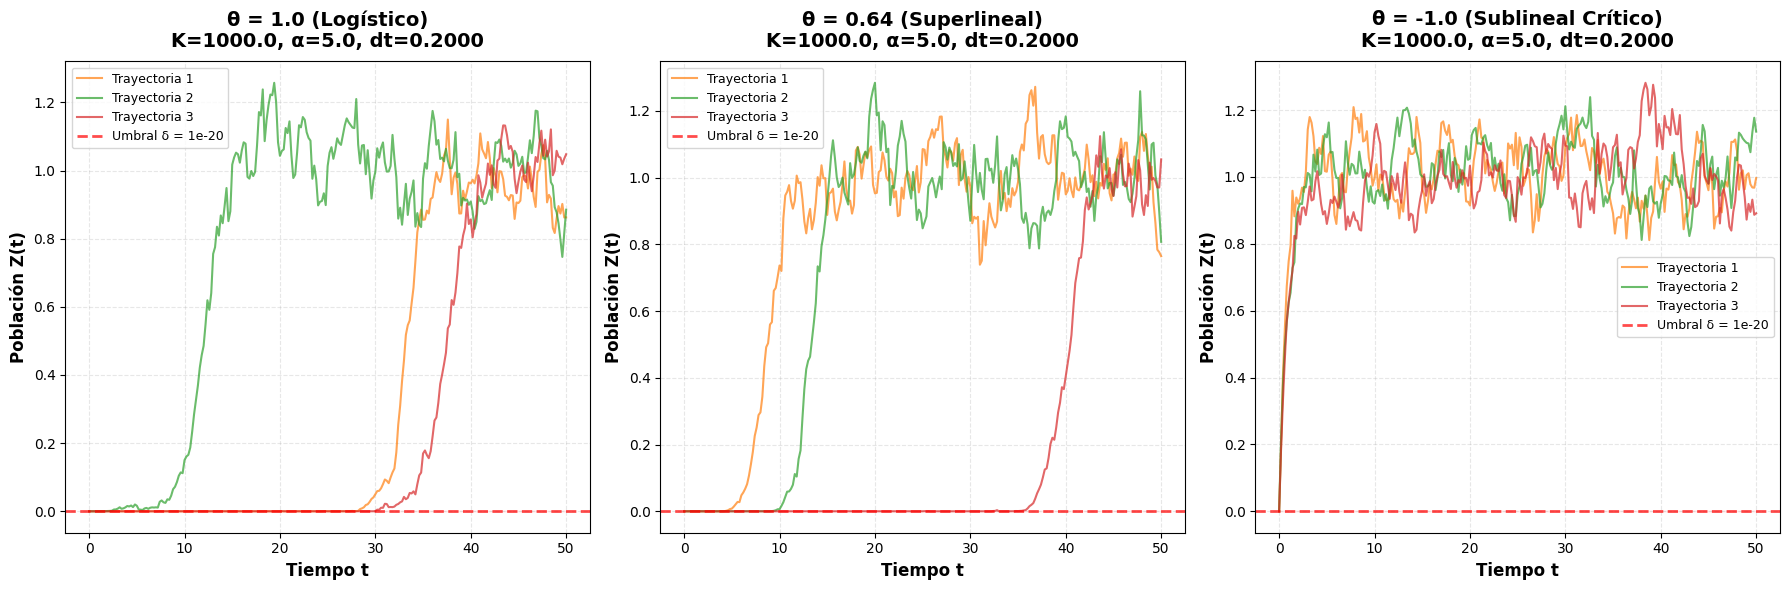

  ✓ Gráfico de trayectorias guardado como 'trayectorias_muestra.png'



In [ ]:
print("Generando visualización de trayectorias de muestra...")

fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # Changed 2,3 to 1,3 for a single row
axes = axes.flatten()

# Vector de tiempo
t = jnp.linspace(0, T, N + 1)
dt = T / N # Calculate dt

# Configuración de colores para las trayectorias
colors = [
          # '#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          # '#9467bd'
          ]

for idx, (theta, label) in enumerate(zip(theta_values, theta_labels)):
    ax = axes[idx]

    # Seleccionar 5 trayectorias aleatorias para visualizar
    sample_indices = jnp.array([
                                # 0,
                                1000,
                                2000,
                                # 5000,
                                8000])

    for i, traj_idx in enumerate(sample_indices):
        trajectory = results[theta][traj_idx, :]
        ax.plot(t, trajectory, alpha=0.7, linewidth=1.5,
                color=colors[i], label=f'Trayectoria {i+1}')

    # Línea de umbral de extinción
    ax.axhline(y=delta, color='red', linestyle='--',
               linewidth=2, alpha=0.7, label=f'Umbral δ = {delta}')

    # Estética del gráfico
    ax.set_xlabel('Tiempo t', fontsize=12, fontweight='bold')
    ax.set_ylabel('Población Z(t)', fontsize=12, fontweight='bold')
    ax.set_title(f"{label}\nK={K}, α={alpha}, dt={dt:.4f}", fontsize=14, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    # ax.set_yscale('log')  # Escala logarítmica para ver mejor el comportamiento cerca de 0
    ax.legend(loc='best', fontsize=9)

    # Sombreado del área de extinción
    ax.fill_between(t, 0, delta, color='red', alpha=0.1)

plt.tight_layout()
plt.savefig('trayectorias_muestra.png', dpi=300, bbox_inches='tight')
plt.show()

print("  ✓ Gráfico de trayectorias guardado como 'trayectorias_muestra.png'\n")

# VISUALIZACIÓN 2: PROBABILIDAD DE EXTINCIÓN AL TIEMPO FINAL

Calculando probabilidades de extinción al tiempo final...


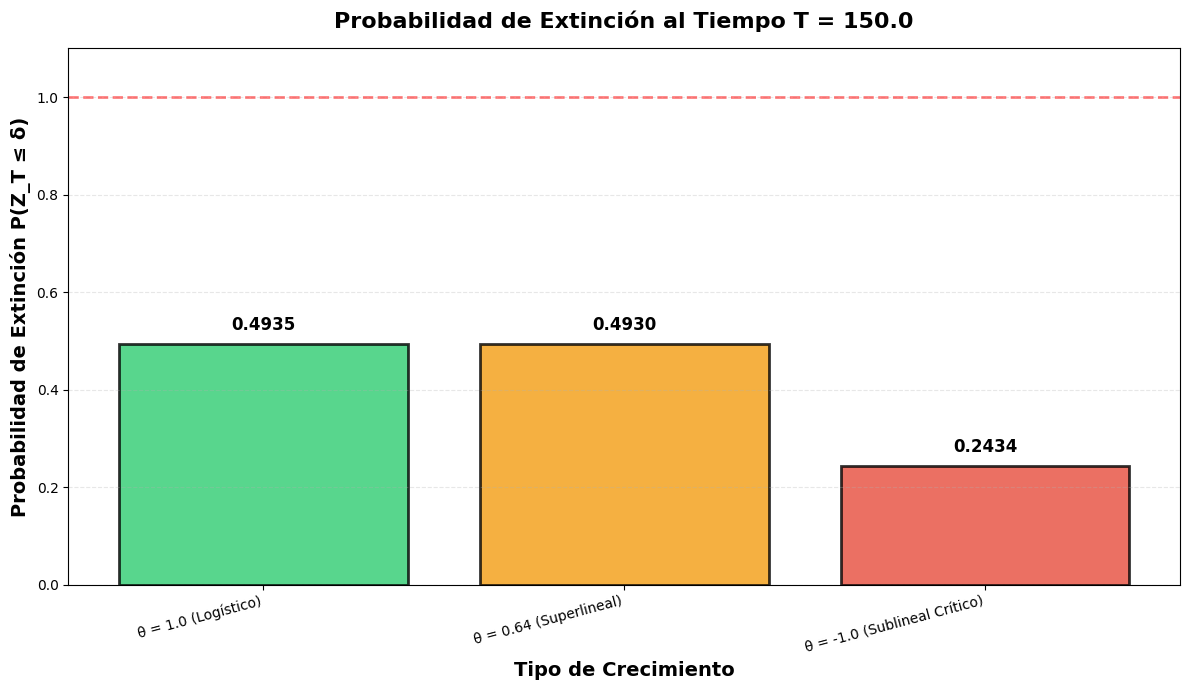

  ✓ Gráfico de probabilidades guardado como 'probabilidad_extincion_final.png'



In [ ]:
print("Calculando probabilidades de extinción al tiempo final...")

extinction_probs = []
for theta in theta_values:
    extinct_count = jnp.sum(results[theta][:, -1] <= delta)
    prob = float(extinct_count / N_sims)
    extinction_probs.append(prob)

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(12, 7))

colors_bar = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad']
bars = ax.bar(range(len(theta_values)), extinction_probs,
              color=colors_bar, alpha=0.8, edgecolor='black', linewidth=2)

# Añadir valores sobre las barras
for i, (bar, prob) in enumerate(zip(bars, extinction_probs)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{prob:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Tipo de Crecimiento', fontsize=14, fontweight='bold')
ax.set_ylabel('Probabilidad de Extinción P(Z_T ≤ δ)', fontsize=14, fontweight='bold')
ax.set_title(f'Probabilidad de Extinción al Tiempo T = {T}',
             fontsize=16, fontweight='bold', pad=15)
ax.set_xticks(range(len(theta_values)))
ax.set_xticklabels(theta_labels, rotation=15, ha='right')
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# Línea de referencia en 100%
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.savefig('probabilidad_extincion_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("  ✓ Gráfico de probabilidades guardado como 'probabilidad_extincion_final.png'\n")

# VISUALIZACIÓN 3: EVOLUCIÓN TEMPORAL DE LA PROBABILIDAD DE EXTINCIÓN

Calculando evolución temporal de la probabilidad de extinción...


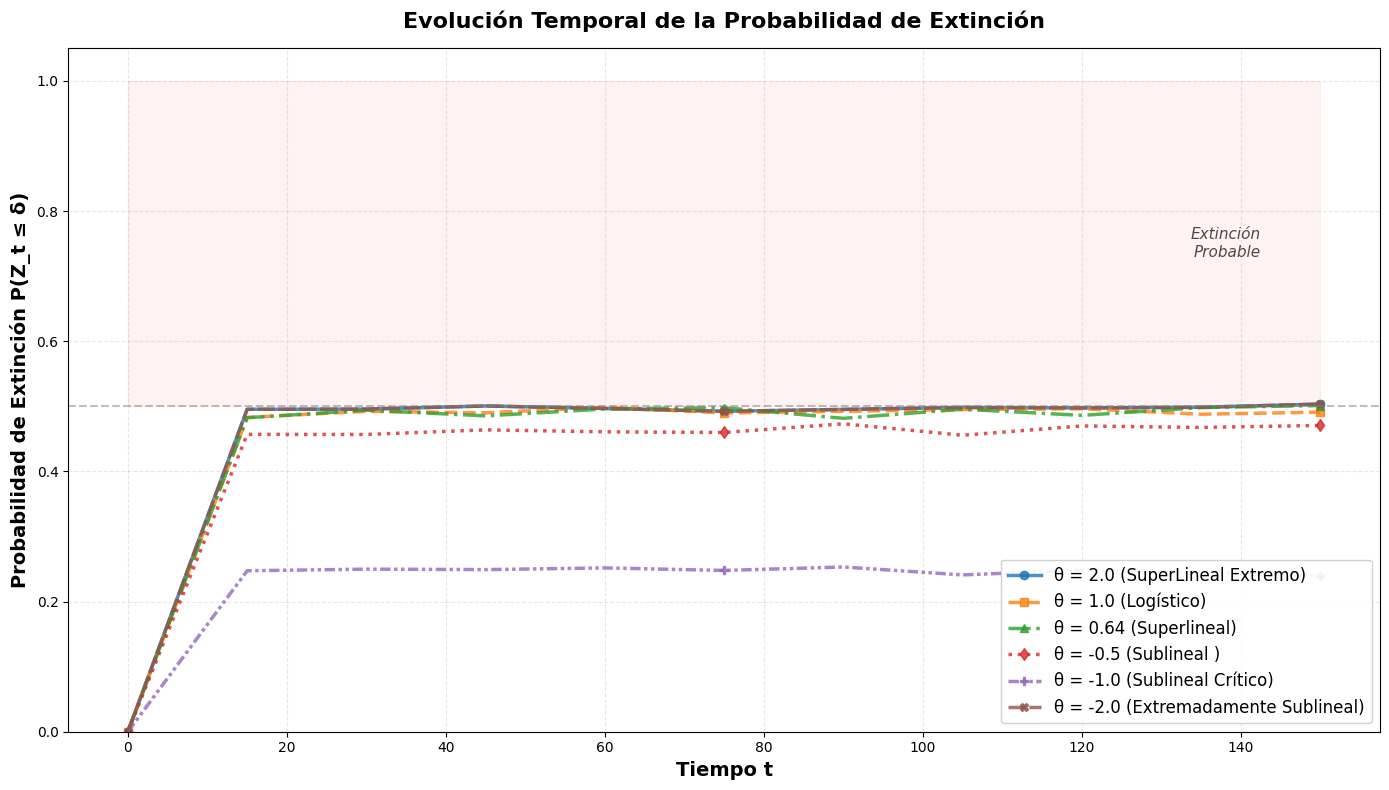

  ✓ Gráfico de evolución guardado como 'evolucion_probabilidad_extincion.png'



In [ ]:
print("Calculando evolución temporal de la probabilidad de extinción...")

# Redefine t to ensure it's available in this cell
t = jnp.linspace(0, T, N + 1)

# Seleccionar puntos temporales para evaluar (cada 100 pasos para eficiencia)
time_indices = jnp.arange(0, N + 1, 100)
time_points = t[time_indices]

# Calcular P(Z_t ≤ δ) para cada tiempo y cada theta
extinction_curves = {}

for theta in theta_values:
    probs_over_time = []
    for idx in time_indices:
        extinct_at_time = jnp.sum(results[theta][:, idx] <= delta)
        prob = float(extinct_at_time / N_sims)
        probs_over_time.append(prob)
    extinction_curves[theta] = jnp.array(probs_over_time)

# Crear gráfico de evolución temporal
fig, ax = plt.subplots(figsize=(14, 8))

# Extend line_styles and markers to match the number of theta_values
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1)), (0, (5, 1))]
markers = ['o', 's', '^', 'd', 'P', 'X']

for i, (theta, label) in enumerate(zip(theta_values, theta_labels)):
    ax.plot(time_points, extinction_curves[theta],
            label=label, linewidth=2.5, linestyle=line_styles[i],
            marker=markers[i], markersize=6, markevery=5, alpha=0.8)

ax.set_xlabel('Tiempo t', fontsize=14, fontweight='bold')
ax.set_ylabel('Probabilidad de Extinción P(Z_t ≤ δ)', fontsize=14, fontweight='bold')
ax.set_title('Evolución Temporal de la Probabilidad de Extinción',
             fontsize=16, fontweight='bold', pad=15)
ax.legend(loc='best', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([0, 1.05])

# Sombreado del área donde P > 0.5 (extinción probable)
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
ax.fill_between(time_points, 0.5, 1.0, color='red', alpha=0.05)
ax.text(T * 0.95, 0.75, 'Extinción\nProbable', ha='right', va='center',
        fontsize=11, style='italic', alpha=0.7)

plt.tight_layout()
plt.savefig('evolucion_probabilidad_extincion.png', dpi=300, bbox_inches='tight')
plt.show()

print("  ✓ Gráfico de evolución guardado como 'evolucion_probabilidad_extincion.png'\n")

# Analisis Estadistico


╔══════════════════════════════════════════════════════════════════════════╗
║    ANÁLISIS DE TIEMPOS DE EXTINCIÓN CON DATAFRAME - SIMULACIÓN SDE      ║
╚══════════════════════════════════════════════════════════════════════════╝
    

Parámetros de simulación:
  • Tiempo final (T): 150.0
  • Pasos temporales (N): 1000 (dt = 0.15)
  • Trayectorias Monte Carlo: 10,000
  • Condición inicial (z₀): 1e-18
  • Capacidad de carga (K): 50
  • Parámetro de ruido (α): 2000.0
  • Umbral de extinción (δ): 1e-20


Simulando θ = 1.0 (Logístico)...
Simulando θ = 0.64 (Superlineal)...
Simulando θ = -1.0 (Sublineal Crítico)...

CREANDO DATAFRAME DE ESTADÍSTICAS


                                     TABLA DE ESTADÍSTICAS DE TIEMPOS DE EXTINCIÓN                                      

    θ                     Etiqueta N_extintas  N_total P(extinción)  Media (μ)  Mediana  Desv_Std (σ)  Varianza (σ²)       CV  Mínimo     Q25      Q75   Máximo      IQR  Asimetría  Curtosis
 1.00          θ = 1.0 (Logístic

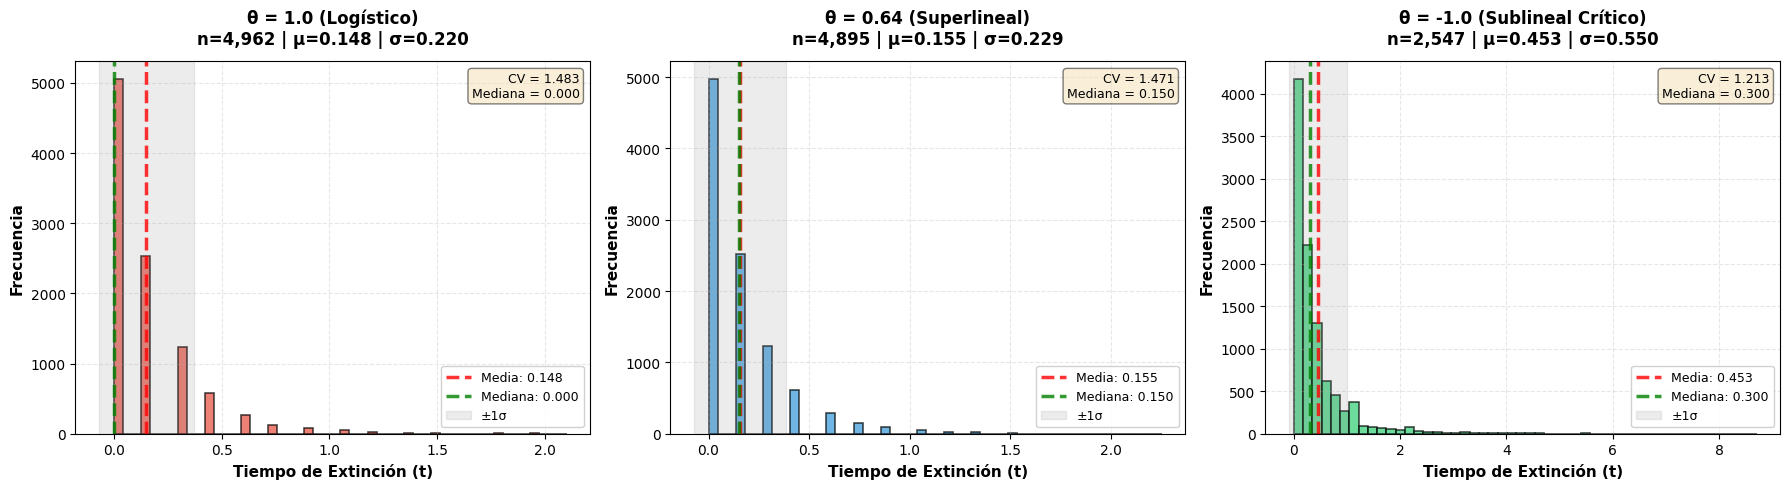

✓ Histogramas guardados como 'histogramas_tiempos_extincion.png'


✓ ANÁLISIS COMPLETO FINALIZADO



In [ ]:
# ============================================================================
# FUNCIÓN PRINCIPAL
# ============================================================================

def main():
    """Ejecuta el análisis completo de tiempos de extinción"""

    print("""
╔══════════════════════════════════════════════════════════════════════════╗
║    ANÁLISIS DE TIEMPOS DE EXTINCIÓN CON DATAFRAME - SIMULACIÓN SDE      ║
╚══════════════════════════════════════════════════════════════════════════╝
    """)

    print("\nParámetros de simulación:")
    print(f"  • Tiempo final (T): {T}")
    print(f"  • Pasos temporales (N): {N} (dt = {T/N})")
    print(f"  • Trayectorias Monte Carlo: {N_sims:,}")
    print(f"  • Condición inicial (z₀): {z0}")
    print(f"  • Capacidad de carga (K): {K}")
    print(f"  • Parámetro de ruido (α): {alpha}")
    print(f"  • Umbral de extinción (δ): {delta}")
    print("\n" + "="*120 + "\n")

    main_key = random.PRNGKey(442)
    all_stats = []

    for i, theta in enumerate(theta_values):
        print(f"Simulando {theta_labels[i]}...")
        main_key, subkey = random.split(main_key)

        trajectories, extinction_times, extinction_steps = \
            run_simulation_with_extinction_times(
                subkey, theta, T, N, N_sims, z0, K, alpha, delta
            )

        stats = compute_extinction_statistics(
            trajectories, extinction_times, theta_labels[i], theta
        )
        all_stats.append(stats)

    print("\n" + "="*120)
    print("CREANDO DATAFRAME DE ESTADÍSTICAS")
    print("="*120 + "\n")

    df_stats = create_statistics_dataframe(all_stats)

    if df_stats is not None:
        display_statistics_table(df_stats)
        export_dataframe(df_stats, 'estadisticas_extincion.csv')

        print("="*120)
        print("📊 DATAFRAME DISPONIBLE EN LA VARIABLE: df_stats")
        print("="*120 + "\n")

    print("\n" + "="*120)
    print("GENERANDO VISUALIZACIONES")
    print("="*120 + "\n")

    plot_extinction_histograms(all_stats, T)

    print("\n" + "="*120)
    print("✓ ANÁLISIS COMPLETO FINALIZADO")
    print("="*120 + "\n")

    return df_stats

if __name__ == "__main__":
    df_statistics = main()